# The ROC-AUC accurately assess imbalanced datasets
##### Eve Richardson, Raphael Trevizani, Jason Greenbaum, Hannah Carter, Morten Nielsen & Bjoern Peters
Code to reproduce the simulations and figures.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, precision_score, recall_score, average_precision_score, roc_curve
import seaborn as sns
from matplotlib import pyplot as plt, patches as mpatches
from matplotlib.patches import ConnectionPatch
from matplotlib.lines import Line2D
from itertools import combinations
from google.colab import drive
import os
from scipy import stats
from statistics import NormalDist
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pickle
import re

imbalance_hex = ['#009E73','#56B4E9', '#CC79A7']
classifier_names = ['Worst', 'Middle', 'Best']
n_repeats = 1000
imbalances_float = [.01, 0.1, 0.5]
imbalances_string = ['1:99','1:9','1:1']
mean_diffs = [0.5, 1, 1.5]

sns.set(font_scale = 1.5, style = 'white')

##Classifier simulations for Figures 3 + Supplementary Figures 1, 2 and 3.

Simulated classifier | Negative | Positive
--- | --- | ---
Worst | N(0, 0) | N(0.5, 0)
Middle | N(0, 0) | N(1, 0)
Best | N(0, 0) | N(1.5, 0)

##Classifier simulations for Figures 4 + Supplementary Figure 4.

Simulated classifier | Negative | Positive
--- | --- | ---
Good ER | Beta(1, 4) | Beta(1, 1)
Bad ER | Beta(1, 1) | Beta(4, 1)

In [ ]:
# @title Drawing score distribution and calculating metrics.
def draw_distrib(n, imbalance,  mean):
  n_pos = int(n * imbalance)
  scores = np.random.normal(0, 1, n)
  scores_pos = np.random.normal(mean, 1, n_pos)
  scores[: n_pos] = scores_pos
  labels = np.zeros(n)
  labels[:n_pos] = 1
  return labels, scores

def er_distrib(n, imbalance, er = 'good', simulation_type = 1):
  n_pos = int(n * imbalance)
  labels = np.zeros(n)
  labels[:n_pos] = 1
  if er == 'good':
     scores = np.random.beta(1, 4, n)
     scores_pos = np.random.beta(1, 1, n_pos)
     scores[:n_pos] = scores_pos
  else:
    scores = np.random.beta(1, 1, n)
    scores_pos = np.random.beta(4, 1, n_pos)
    scores[:n_pos] = scores_pos
  return labels, scores

def performance_table(n_repeats, mean_diffs, imbalances, size = 10000):
  repeats = {}
  for n in range(n_repeats):
    repeats[n] = {}
    for imbalance in imbalances:
      for mean in mean_diffs:
        repeats[n][(imbalance, mean)] = draw_distrib(size, imbalance, mean)
  pr_estimates = {'imbalance':[], 'PR-AUC':[], 'ROC-AUC':[], 'ROC-AUC_0.1':[], 'repeat':[], 'mean_diff':[]}
  for n in repeats:
    for imbalance in imbalances:
      estimates = {}
      for mean in mean_diffs:
          estimates[mean] = average_precision_score(*repeats[n][(imbalance, mean)]), roc_auc_score(*repeats[n][(imbalance, mean)]), roc_auc_score(*repeats[n][(imbalance, mean)], max_fpr = .1)
      for mean in mean_diffs:
        pr_estimates['imbalance'].append(imbalance)
        pr_estimates['PR-AUC'].append(estimates[mean][0])
        pr_estimates['ROC-AUC'].append(estimates[mean][1])
        pr_estimates['repeat'].append(n)
        pr_estimates['mean_diff'].append(mean)
        pr_estimates['ROC-AUC_0.1'].append(estimates[mean][-1])
  return pd.DataFrame(pr_estimates), repeats


def performance_table_beta(n_repeats, imbalances, size = 10000):
  repeats = {}
  for n in range(n_repeats):
    repeats[n] = {}
    for imbalance in imbalances:
      for er in ['good','bad']:
        repeats[n][(imbalance, er)] = er_distrib(size, imbalance, er)
  pr_estimates = {'imbalance':[], 'PR-AUC':[], 'ROC-AUC':[], 'ROC-AUC_0.1':[], 'repeat':[], 'mean_diff':[]}
  for n in repeats:
    for imbalance in imbalances:
      for er in ['good','bad']:
        pr_estimates['imbalance'].append(imbalance)
        pr_estimates['PR-AUC'].append(average_precision_score(*repeats[n][(imbalance, er)]))
        pr_estimates['ROC-AUC'].append(roc_auc_score(*repeats[n][(imbalance, er)]))
        pr_estimates['ROC-AUC_0.1'].append(roc_auc_score(*repeats[n][(imbalance, er)], max_fpr = .1))
        pr_estimates['mean_diff'].append(er)
        pr_estimates['repeat'].append(n)
  return pd.DataFrame(pr_estimates), repeats


def calc_estimates_diff(pr_estimates, means, norm = True):
  pr_estimates_diff = {'mean_diff':[],'lower_ci':[],'upper_ci':[],'p1':[],'p2':[],'imbalance':[],'metric':[],'sem':[],'err':[],'n':[]}
  for k,p in pr_estimates.groupby('imbalance'):
    for p1, p2 in combinations(means, 2):
      if means == ['good','bad']:
        p1 = 'bad'
        p2 = 'good'
      vals1 = p[p['mean_diff']==p1]
      vals2 = p[p['mean_diff']==p2]
      for key in ['ROC-AUC','PR-AUC','ROC-AUC_0.1']:
        vals_1 = vals1[key].values
        vals_2 = vals2[key].values
        diff = (vals_1 - vals_2)/vals_2 if norm else vals_1 - vals_2
        mean = np.mean(diff)
        sem = stats.sem(diff)
        tstat = stats.t(df = len(diff) - 1).ppf((1 + 0.95) /2)
        W = tstat * np.std(diff, ddof=1) / np.sqrt(len(diff))
        pr_estimates_diff['mean_diff'].append(mean)
        pr_estimates_diff['lower_ci'].append(mean-sem*tstat)
        pr_estimates_diff['upper_ci'].append(mean+sem*tstat)
        pr_estimates_diff['sem'].append(sem)
        pr_estimates_diff['p1'].append(p1)
        pr_estimates_diff['p2'].append(p2)
        pr_estimates_diff['imbalance'].append(k)
        pr_estimates_diff['metric'].append(key)
        pr_estimates_diff['err'].append(W)
        pr_estimates_diff['n'].append(len(diff))
  pr_estimates_diff = pd.DataFrame(pr_estimates_diff)
  return pr_estimates_diff

In [ ]:
relabel_imbalances = {.01: '1:99', .1: '1:9', .5: '1:1'}
pr_estimates, datasets = performance_table(n_repeats, mean_diffs, imbalances_float)
pr_estimates['PR-AUC_Marginal'] = pr_estimates['PR-AUC'] - pr_estimates['imbalance']
pr_estimates['PR-AUC_Ratio'] = pr_estimates['PR-AUC_Marginal'] / (pr_estimates['imbalance'])
pr_estimates['PR-AUC_Normalized'] = pr_estimates['PR-AUC'] / pr_estimates['imbalance']
pr_estimates['PR-AUC_Normalized_SqrdDenom'] = pr_estimates['PR-AUC'] / pr_estimates['imbalance']**2
pr_estimates['PR-AUC_Scaled'] = (pr_estimates['PR-AUC'] - pr_estimates['imbalance'])/(1 - pr_estimates['imbalance'])
pr_estimates['Classifier type'] = pr_estimates['mean_diff'].map(lambda x:'Worst' if x==0.5 else 'Middle' if x== 1 else 'Best')
pr_estimates_er, datasets_er = performance_table_beta(n_repeats,  imbalances_float)
pr_estimates_er['PR-AUC_Marginal'] = pr_estimates_er['PR-AUC'] - pr_estimates_er['imbalance']
pr_estimates_er['PR-AUC_Ratio'] = pr_estimates_er['PR-AUC_Marginal'] / pr_estimates_er['imbalance']
pr_estimates_er['PR-AUC_Normalized'] = pr_estimates_er['PR-AUC'] / pr_estimates_er['imbalance']
pr_estimates_er['PR-AUC_Normalized_SqrdDenom'] = pr_estimates_er['PR-AUC'] / pr_estimates_er['imbalance']**2
pr_estimates['imbalance'] = pr_estimates['imbalance'].map(relabel_imbalances)
pr_estimates_er['imbalance'] = pr_estimates_er['imbalance'].map(relabel_imbalances)

figure_dir = '.'
pr_estimates.to_csv(os.path.join(figure_dir,f'PR_Estimates.csv'))
pr_estimates_er.to_csv(os.path.join(figure_dir,f'PR_Estimates_ER.csv'))
with open(os.path.join(figure_dir,f'NormDatasets.p'), 'wb') as k:
  pickle.dump(datasets, k)
with open(os.path.join(figure_dir,f'BetaDatasets.p'), 'wb') as k:
  pickle.dump(datasets_er, k)

In [ ]:
# figure_dir = '/content/drive/MyDrive/ROC-AUC_FinalFigs'

relabel_imbalances = {.01: '1:99', .1: '1:9', .5: '1:1'}

pr_estimates = pd.read_csv(os.path.join(figure_dir,f'PR_Estimates.csv'))
pr_estimates_er = pd.read_csv(os.path.join(figure_dir,f'PR_Estimates_ER.csv'))
datasets = pd.read_pickle(os.path.join(figure_dir,f'NormDatasets.p'))
datasets_er = pd.read_pickle(os.path.join(figure_dir,f'BetaDatasets.p'))

In [ ]:
# @title Ugly plotting functions :)

def recolor_boxplots(axis, palette, n_boxes):
  box_patches = [patch for patch in axis.patches if type(patch) == mpatches.PathPatch]
  num_patches = len(box_patches)
  lines_per_boxplot = len(axis.lines) // num_patches
  color_idx = 0
  palette = palette * n_boxes
  for i, patch in enumerate(box_patches):
      col = patch.get_facecolor()
      color_idx = i // n_boxes
      patch.set_edgecolor(palette[color_idx])
      patch.set_facecolor('None')
      for line in axis.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
          line.set_color(palette[color_idx])
          line.set_mfc(palette[color_idx])
          line.set_mec(palette[color_idx])

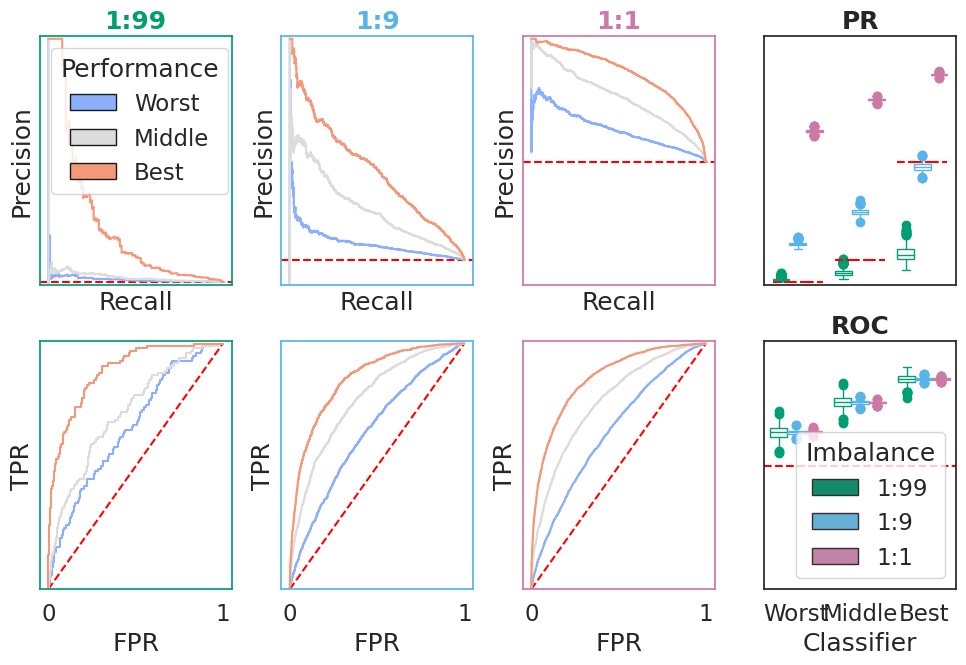

In [ ]:
# @title Figure 3

dtype = 'Normal'
dataset_dict = datasets_er if dtype == 'ER' else datasets

fig, axs = plt.subplots(2,4,figsize=(10,7),sharey=True)
colors = sns.color_palette("coolwarm", n_colors=3)

repeat = np.random.randint(1000)
for n, chosen_imbalance in enumerate(imbalances_float):
  axs[0][n].axhline(chosen_imbalance, color = 'red', linestyle = '--')
  axs[1][n].plot([0,1],[0,1], color = 'red', linestyle = '--')
  for k, p in enumerate(mean_diffs):
    labels, scores = dataset_dict[repeat][(chosen_imbalance, p)]
    precision, recall, _ = precision_recall_curve(labels, scores)
    fpr, tpr, _ = roc_curve(labels, scores)
    if n != 0:
      axs[0][n].set_yticks([])
      axs[1][n].set_yticks([])
    axs[0][n].set_xticks([])
    axs[0][n].plot(recall, precision, color = colors[k])
    axs[0][n].set_xlabel('Recall')
    axs[0][n].set_ylabel("Precision")
    axs[1][n].plot(fpr, tpr, color = colors[k])
    axs[1][n].set_xlabel('FPR')
    axs[1][n].set_ylabel('TPR')



pos_patch = mpatches.Patch(facecolor=colors[0], label='Worst', edgecolor = 'k')
negative_patch = mpatches.Patch(facecolor=colors[1], label='Middle', edgecolor = 'k')
third_patch = mpatches.Patch(facecolor=colors[2], label='Best', edgecolor = 'k')
axs[0][0].legend(handles = [pos_patch,negative_patch,third_patch],title='Performance')

for n,x in enumerate(imbalances_string):
  axs[0][n].set_title(x, weight = 'bold', color = imbalance_hex[n])
  for spine in axs[0][n].spines.values():
      spine.set_edgecolor(imbalance_hex[n])
  for spine in axs[1][n].spines.values():
      spine.set_edgecolor(imbalance_hex[n])

sns.boxplot(data = pr_estimates[pr_estimates['mean_diff'].isin(mean_diffs)], x='Classifier type', y ='ROC-AUC', ax = axs[1][-1], hue = 'imbalance', palette = imbalance_hex)
sns.boxplot(data = pr_estimates[pr_estimates['mean_diff'].isin(mean_diffs)], x='Classifier type', y ='PR-AUC', ax = axs[0][-1], hue = 'imbalance', palette = imbalance_hex)

recolor_boxplots(axs[1][3], imbalance_hex, 3)
recolor_boxplots(axs[0][3], imbalance_hex, 3)

n = 0
for patch in axs[0][3].patches:
  if type(patch) == mpatches.PathPatch:
    trans = patch.get_patch_transform()
    points = trans.transform(patch.get_path().vertices)
    index = n%3
    axs[0][3].plot([points[0][0],points[1][0]], [imbalances_float[index]]*2, color = 'red', linestyle = '--')
    n += 1

axs[0][3].set_xlabel('')
axs[1][3].set_xlabel('Classifier')
axs[1][3].set_ylim(0,1.01)
axs[1][3].set_ylabel('AUC')
axs[0][3].set_ylabel('AUC')
axs[1][3].set_title(f"ROC", weight='bold')
axs[0][3].set_title('PR', weight = 'bold')
axs[1][3].get_legend().set_title('Imbalance')
axs[0][3].set_xticks([])
axs[0][3].get_legend().remove()
axs[1][3].get_legend().get_bbox_to_anchor()
axs[1][3].axhline(0.5, linestyle = '--', color = 'red' )
fig.tight_layout(w_pad=0)
for p in range(2):
  axs[p][0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  axs[p][3].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

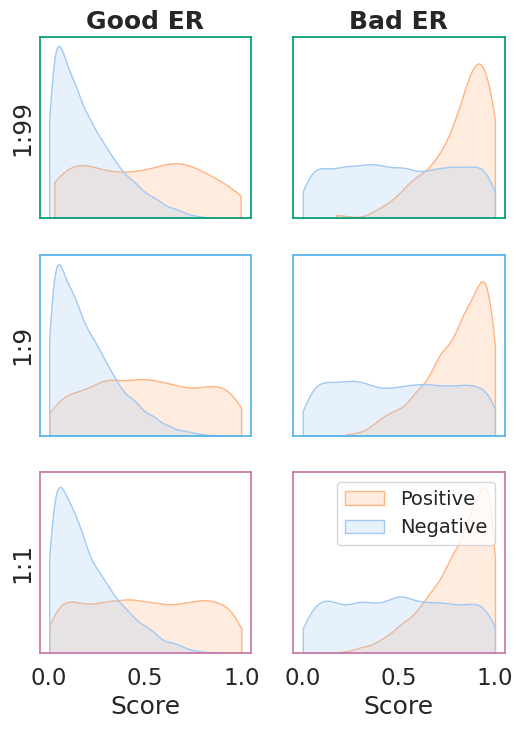

In [73]:
# @title Figure 4ABC
fig, axs = plt.subplots(len(imbalances_float), 2, figsize=(6,8), sharex= True,sharey=True)
for n,imbalance in enumerate(imbalances_float):
  for k in range(0,2):
    ax = axs[n][k]
    sns.kdeplot(pd.DataFrame(datasets_er[repeat][(imbalance, ['good','bad'][k])]).T,  x = 1, hue = 0, palette='pastel', common_norm = False, ax = ax, legend = False, cut = 0, fill = True)
    axs[k][0].set_ylabel(imbalances_string[n],rotation=90)
    ax.set_xlabel('Score')
    axs[0][k].set_title(['Good','Bad'][k] + ' ER', weight = 'bold')

for n, imbalance in enumerate(imbalances_string):
  axs[n][0].set_yticks([])
  axs[n][0].set_ylabel(imbalance,rotation=90)
  for spine in axs[n][0].spines.values():
      spine.set_edgecolor(imbalance_hex[n])
  for spine in axs[n][1].spines.values():
      spine.set_edgecolor(imbalance_hex[n])

plt.legend(['Positive','Negative'], fontsize=14)

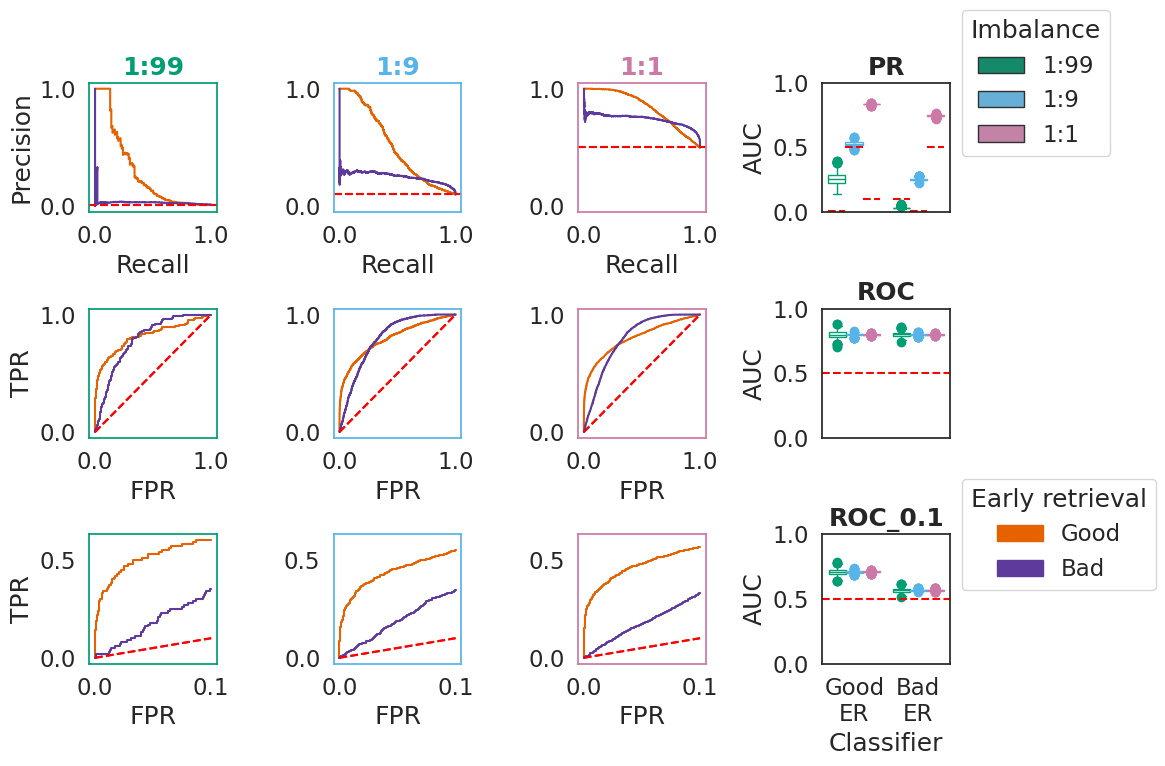

In [76]:
# @title Figure 4DEF
dtype = 'ER'
dataset_dict = datasets_er if dtype == 'ER' else datasets
max_fpr = 0.1


colors = ['#E66100','#5D3A9B']

fig, axs = plt.subplots(3,4,figsize=(12,8))
repeat = np.random.randint(len(datasets_er))

sns.boxplot(data = pr_estimates_er, x='mean_diff', y ='PR-AUC', ax = axs[0][3], hue = 'imbalance', palette = imbalance_hex)
sns.boxplot(data = pr_estimates_er, x='mean_diff', y ='ROC-AUC', ax = axs[1][3], hue = 'imbalance', palette = imbalance_hex)
sns.boxplot(data = pr_estimates_er, x='mean_diff', y ='ROC-AUC_0.1', ax = axs[2][3], hue = 'imbalance', palette = imbalance_hex)

recolor_boxplots(axs[0][3], imbalance_hex, 2)
recolor_boxplots(axs[1][3], imbalance_hex, 2)
recolor_boxplots(axs[2][3], imbalance_hex, 2)

for n in range(3):
  if n != 0:
    axs[n][3].get_legend().remove()
  else:
    axs[n][3].get_legend().set_title('Imbalance')
  axs[n][3].set_ylim(0,1)
  axs[n][3].set_xticks([])
  axs[n][3].set_xlabel('')
  axs[n][3].set_ylabel('AUC')
  axs[n][3].set_title(['PR','ROC','ROC_0.1'][n], fontweight='bold')
axs[-1][3].set_xticks([0,1], ['Good\nER','Bad\nER'])
axs[-1][3].set_xlabel('Classifier')

n = 0
for patch in axs[0][3].patches:
  if type(patch) == mpatches.PathPatch:
    trans = patch.get_patch_transform()
    points = trans.transform(patch.get_path().vertices)
    index = n%3
    axs[0][3].plot([points[0][0],points[1][0]], [imbalances_float[index]]*2, color = 'red', linestyle = '--')
    n += 1

axs[1][3].axhline(0.5,linestyle='--',color='red')
axs[2][3].axhline(0.5, linestyle = '--', color = 'red')

for n in range(1,3):
  for x in range(0,3):
    axs[x][n].set_ylabel('')
for n in range(0,3):
  axs[0][n].set_ylabel("Precision")
  axs[1][n].set_ylabel('TPR')
  axs[2][n].set_ylabel('TPR')
  axs[0][n].set_xlabel('Recall')
  axs[1][n].set_xlabel('FPR')
  axs[2][n].set_xlabel('FPR')
for n in range(1,3):
  for axis in range(3):
    axs[axis][n].set_ylabel('')



for k,p in enumerate(['good', 'bad']):
  for n, chosen_imbalance in enumerate(imbalances_float):
    labels, scores = dataset_dict[repeat][(chosen_imbalance, p)]
    precision, recall, _ = precision_recall_curve(labels, scores)
    fpr, tpr, _ = roc_curve(labels, scores)
    axs[0][n].plot(recall,precision,color=colors[k])
    axs[1][n].plot(fpr,tpr,color=colors[k])
    axs[0][n].sharey(axs[0][0])
    axs[1][n].sharey(axs[1][0])
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    axs[2][n].plot(fpr, tpr, color=colors[k])
    axs[1][n].plot([0,1],[0,1], color='red', linestyle='--')
    axs[0][n].axhline(chosen_imbalance, color='red', linestyle='--')
    axs[2][n].plot([0,0.1],[0,0.1],linestyle='--',color='red')
    axs[2][n].sharey(axs[2][0])

pos_patch = mpatches.Patch(color=colors[0], label='Good')
negative_patch = mpatches.Patch(color=colors[1], label='Bad')
plt.legend(handles = [pos_patch,negative_patch],title='Early retrieval')

for n,x in enumerate(imbalances_string):
  axs[0][n].set_title(x, weight = 'bold', color = imbalance_hex[n])
  for spine in axs[0][n].spines.values():
      spine.set_edgecolor(imbalance_hex[n])
  for spine in axs[1][n].spines.values():
      spine.set_edgecolor(imbalance_hex[n])
  for spine in axs[2][n].spines.values():
      spine.set_edgecolor(imbalance_hex[n])


plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.tight_layout()
for p in range(3):
  for x in range(3):
    axs[p][x].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axs[p][x].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

for p in [0, 2]:
  sns.move_legend(axs[p][-1], 'center left', bbox_to_anchor = (1,1))
fig.tight_layout()

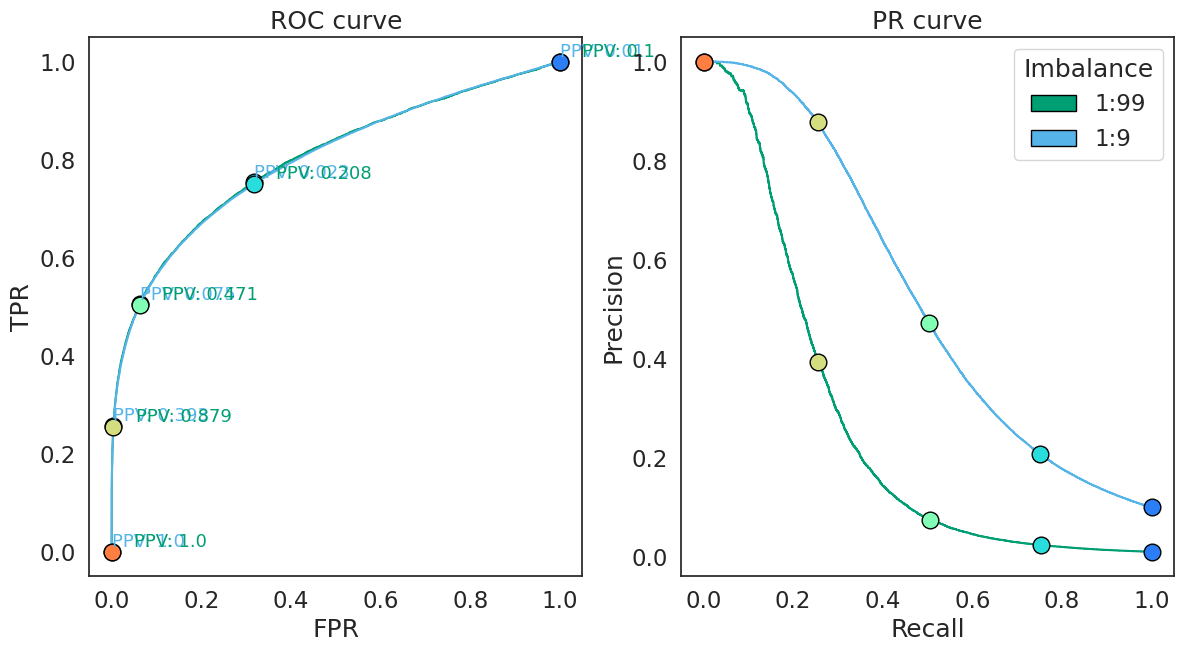

In [78]:
from sklearn.metrics import confusion_matrix
fig, axs = plt.subplots(1,2,figsize=(14,7))
repeats = np.random.randint(0, len(datasets_er), 100)
gb_colors = ['#E66100','#5D3A9B']
labels = np.hstack([datasets_er[repeat][(.01, 'good')][0] for repeat in repeats])
scores =  np.hstack([datasets_er[repeat][(.01, 'good')][1] for repeat in repeats])
fpr, tpr, _ = roc_curve(labels, scores)
precision_values, recall, _ = precision_recall_curve(labels, scores)
axs[0].plot(fpr, tpr,color=imbalance_hex[0])
axs[1].plot(recall, precision_values,color=imbalance_hex[0])
colors = sns.color_palette('rainbow', n_colors = 5)
score_range = 0, max(scores)
fprs = {.01:{},.1:{}}
for n, score in enumerate(np.linspace(score_range[0], score_range[1], 5)):
  preds = np.array(scores >= score, dtype = int)
  tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
  precision = precision_score(labels, preds)
  tpr = tp/sum(labels)
  fpr = fp/(fp+tn)
  fprs[.01][score] = fpr, tpr
  axs[0].plot(fpr, tpr, 'o', color = 'black', ms = 12, markerfacecolor=colors[n])
  axs[1].plot(tpr, precision, 'o', color = 'black',markerfacecolor=colors[n], ms = 12)
  precision = np.around(precision, 3)
  axs[0].text(fpr, tpr+.01, f'PPV: {precision}', size = 13, color = imbalance_hex[1])
axs[0].set_xlabel('FPR')
axs[0].set_ylabel('TPR')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')

labels = np.hstack([datasets_er[repeat][(.1, 'good')][0] for repeat in repeats])
scores =  np.hstack([datasets_er[repeat][(.1, 'good')][1] for repeat in repeats])
fpr, tpr, _ = roc_curve(labels, scores)
precision_values, recall, _ = precision_recall_curve(labels, scores)
axs[0].plot(fpr, tpr,color=imbalance_hex[1])
axs[1].plot(recall, precision_values,color=imbalance_hex[1])
for n, score in enumerate(np.linspace(score_range[0], score_range[1], 5)):
  preds = np.array(scores >= score, dtype = int)
  tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
  precision = precision_score(labels, preds)
  tpr = tp/sum(labels)
  fpr = fp/(fp+tn)
  fprs[.1][score] = fpr, tpr
  axs[0].plot(fpr, tpr, 'o', color = 'black', ms = 12, markerfacecolor=colors[n])
  axs[1].plot(tpr, precision, 'o', color = 'black',markerfacecolor=colors[n], ms = 12)
  precision = np.around(precision, 3)
  axs[0].text(fpr+0.05, tpr+.01, f'PPV: {precision}', size = 13, color = imbalance_hex[0])
axs[0].set_xlabel('FPR')
axs[0].set_ylabel('TPR')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[0].set_title('ROC curve')
axs[1].set_title('PR curve')
red_patch = mpatches.Patch(facecolor=imbalance_hex[0], edgecolor = 'black', label='1:99')
pink_patch = mpatches.Patch(facecolor=imbalance_hex[1], edgecolor = 'black', label='1:9')
plt.legend(handles = [red_patch,pink_patch], title = 'Imbalance')
plt.savefig(os.path.join(figure_dir,'PPV_GoodBad.svg'), format = 'svg', dpi = 600)

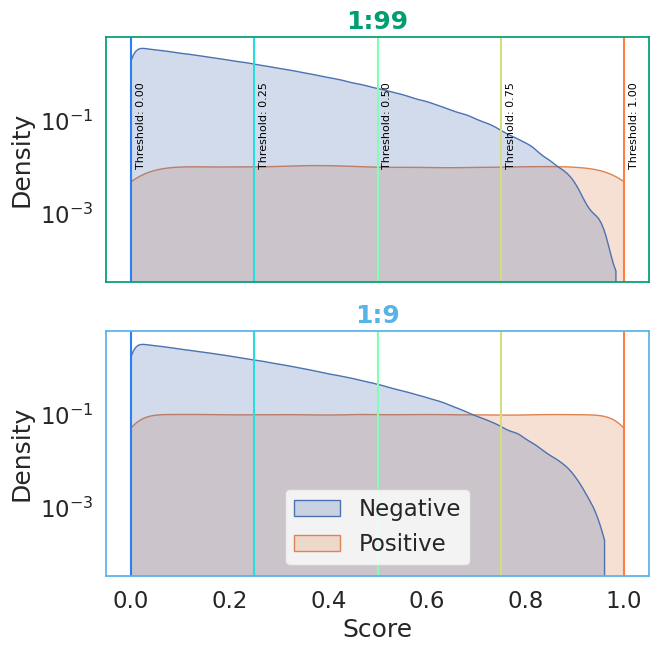

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(7,7),sharey=True, sharex=True)
# plot_one = pd.concat([pd.DataFrame(datasets_er[repeat][(.01, 'good')]).T for repeat in repeats]).rename(columns={0:'Label',1:'Score'})
# plot_one['Label'] = plot_one['Label'].map(lambda x:'Positive' if x == 1 else 'Negative')
plot_two = pd.concat([pd.DataFrame(datasets_er[repeat][(.1, 'good')]).T for repeat in repeats]).rename(columns={0:'Label',1:'Score'})
plot_two['Label'] = plot_two['Label'].map(lambda x:'Positive' if x == 1 else 'Negative')
sns.kdeplot(data = plot_one.sort_values('Label'), ax = axs[0], hue = 'Label', x= 'Score', cut = 0, fill = True)
sns.kdeplot(data = plot_two.sort_values('Label'), ax = axs[1], hue = 'Label', x= 'Score', cut = 0, fill = True)
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[0].get_legend().remove()
axs[1].get_legend().set_title('')
# sns.kdeplot(data = scores[np.where(labels==1)], ax = axs[0], color = 'C1', cut = True, fill = True)
for n, score in enumerate(np.linspace(score_range[0], score_range[1], 5)):
  axs[0].axvline(score, color = colors[n], linewidth = 1.5)
  axs[1].axvline(score, color = colors[n], linewidth = 1.5)
  axs[0].text(score+.01, 0.01, f'Threshold: {score:.2f}', rotation = 90, size = 8, color = 'black')
for n,x in enumerate(imbalances_string[:2]):
  axs[n].set_title(x, weight = 'bold', color = imbalance_hex[n])
  for spine in axs[n].spines.values():
      spine.set_edgecolor(imbalance_hex[n])
  for spine in axs[n].spines.values():
      spine.set_edgecolor(imbalance_hex[n])
  for spine in axs[n].spines.values():
      spine.set_edgecolor(imbalance_hex[n])
plt.savefig(os.path.join(figure_dir,'PPV_GoodBad_DensityPlot.png'), format = 'png', dpi = 600, bbox_inches = 'tight')

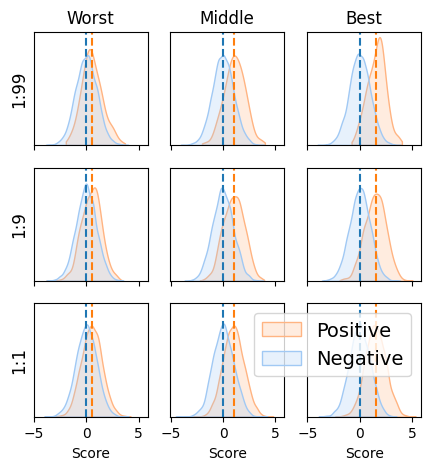

In [ ]:
# @title Supplementary Figure 1
common_norm = False
fig, axs = plt.subplots(len(imbalances_float), len(mean_diffs),figsize=(5,5), sharex=True ,sharey=True)
repeat = np.random.randint(n_repeats)
for n, imbalance in enumerate(imbalances_float):
  for k, i in enumerate(mean_diffs):
    ax = axs[n][k]
    sns.kdeplot(pd.DataFrame(datasets[repeat][(imbalance, i)]).T, x = 1, hue = 0, palette='pastel', common_norm = common_norm, ax=ax, legend=False, cut = True, fill = True)
    ax.set_xlabel('Score')
    axs[0][k].set_title(['Worst','Middle','Best'][k])
    ax.axvline(0,linestyle='--',color='C0')
    ax.axvline(i,linestyle='--',color='C1')
for n, imbalance in enumerate(imbalances_float):
  axs[n][0].set_yticks([])
  axs[n][0].set_ylabel(relabel_imbalances[imbalance], rotation = 90, fontsize = 12)
plt.legend(['Positive','Negative'], fontsize = 14)
# plt.savefig(os.path.join(figure_dir, f'DistributionCheck.png'), dpi=600, bbox_inches='tight')

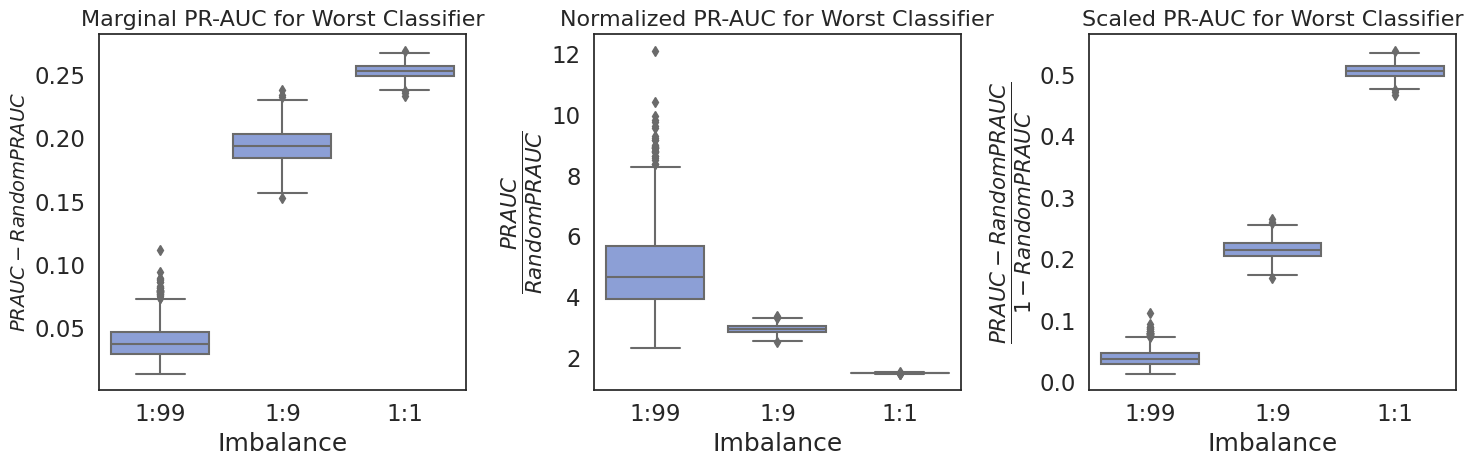

In [ ]:
# @title Supplementary Figure 2

mean_diff = 1
classifier_type = 'Worst'
range_line = (0.6,0.88)
fig, axs = plt.subplots(1,3,figsize=(15,5))
sns.boxplot(data = pr_estimates[pr_estimates['mean_diff']==mean_diff], x='imbalance', y ='PR-AUC_Marginal', color='#8099e2', ax = axs[0])
sns.boxplot(data = pr_estimates[pr_estimates['mean_diff']==mean_diff], x='imbalance', y ='PR-AUC_Normalized', color='#8099e2', ax = axs[1])
sns.boxplot(data = pr_estimates[pr_estimates['mean_diff']==mean_diff], x='imbalance', y ='PR-AUC_Scaled', color='#8099e2', ax = axs[2])

axs[0].set_xlabel('Imbalance')
axs[0].set_title(f'Marginal PR-AUC for {classifier_type} Classifier', size = 16)
axs[0].set_ylabel(r'$PRAUC - Random PRAUC$', size = 14)

axs[1].set_xlabel('Imbalance')
axs[1].set_title(f'Normalized PR-AUC for {classifier_type} Classifier', size = 16)
axs[1].set_ylabel(r'$\frac{PRAUC}{Random PRAUC}$', size = 22)

axs[2].set_xlabel('Imbalance')
axs[2].set_title(f'Scaled PR-AUC for {classifier_type} Classifier', size = 16)
axs[2].set_ylabel(r'$\frac{PRAUC - Random PRAUC}{1 - Random PRAUC}$', size = 22)
for ax in axs:
  ax.set_xticklabels(imbalances_string)
fig.tight_layout()

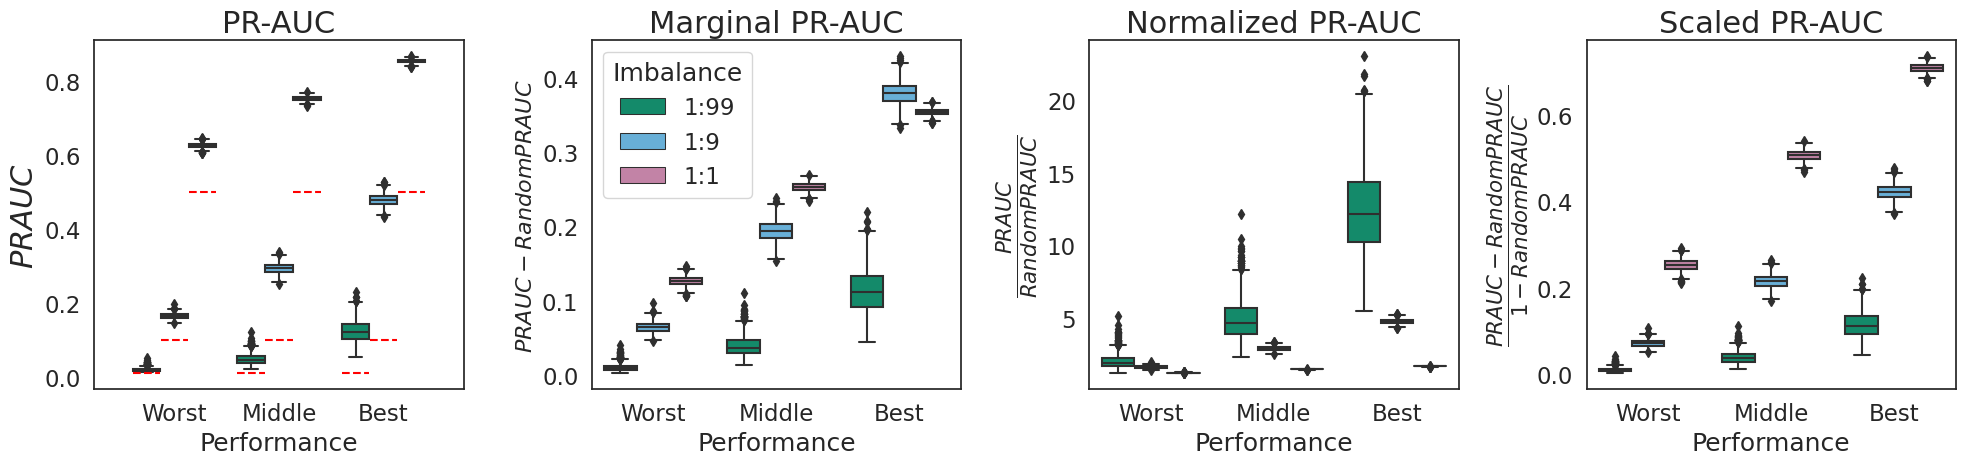

In [ ]:
# @title Supplementary Figure 2


fig, axs = plt.subplots(1,4,figsize=(20,5))
pr_estimates = pd.read_csv(os.path.join(figure_dir,f'PR_Estimates_{simulation_type}.csv'))
pr_estimates['Performance'] = pr_estimates['mean_diff'].map(lambda x:'Worst' if x == 0.5 else 'Middle' if x == 1 else 'Best')
pr_estimates['PR-AUC_Marginal'] = pr_estimates['PR-AUC'] - pr_estimates['imbalance']
pr_estimates['PR-AUC_Ratio'] = pr_estimates['PR-AUC_Marginal'] / (pr_estimates['imbalance'])
pr_estimates['PR-AUC_Normalized'] = pr_estimates['PR-AUC'] / pr_estimates['imbalance']
pr_estimates['PR-AUC_Normalized_SqrdDenom'] = pr_estimates['PR-AUC'] / pr_estimates['imbalance']**2
pr_estimates['PR-AUC_Scaled'] = (pr_estimates['PR-AUC'] - pr_estimates['imbalance'])/(1 - pr_estimates['imbalance'])
pr_estimates['Classifier type'] = pr_estimates['mean_diff'].map(lambda x:'Worst' if x==0.5 else 'Middle' if x== 1 else 'Best')
pr_estimates['imbalance'] = pr_estimates['imbalance'].map(lambda x:'1:99' if x == .01 else '1:9' if x == .1 else '1:1')

sns.boxplot(data = pr_estimates, x='Performance', y ='PR-AUC', hue = 'imbalance', ax = axs[0], palette = imbalance_hex)
sns.boxplot(data = pr_estimates, x='Performance', y ='PR-AUC_Marginal', hue = 'imbalance', ax = axs[1], palette = imbalance_hex)
sns.boxplot(data = pr_estimates, x='Performance', y ='PR-AUC_Normalized', hue = 'imbalance', ax = axs[2], palette = imbalance_hex)
sns.boxplot(data = pr_estimates, x='Performance', y ='PR-AUC_Scaled', hue = 'imbalance', ax = axs[3], palette = imbalance_hex)


axs[0].set_xlabel('Performance')
axs[0].set_title(f'PR-AUC', size = 22)
axs[0].set_ylabel(r'$PRAUC$', size = 22)

n = 0
for patch in axs[0].patches:
  if type(patch) == mpatches.PathPatch:
    trans = patch.get_patch_transform()
    points = trans.transform(patch.get_path().vertices)
    index = n%3
    axs[0].plot([points[0][0],points[1][0]], [imbalances_float[index]]*2, color = 'red', linestyle = '--')
    n += 1

axs[1].set_xlabel('Performance')
axs[1].set_title(f'Marginal PR-AUC', size = 22)
axs[1].set_ylabel(r'$PRAUC - Random PRAUC$', size = 16)

axs[2].set_xlabel('Performance')
axs[2].set_title(f'Normalized PR-AUC', size = 22)
axs[2].set_ylabel(r'$\frac{PRAUC}{Random PRAUC}$', size = 22)

axs[3].set_xlabel('Performance')
axs[3].set_title(f'Scaled PR-AUC', size = 22)
axs[3].set_ylabel(r'$\frac{PRAUC - Random PRAUC}{1 - Random PRAUC}$', size = 22)

for n, ax in enumerate(axs):
  if n != 1:
    ax.get_legend().remove()
  else:
    ax.get_legend().set_title('Imbalance')
  # ax.set_xticklabels(imbalances_string)
fig.tight_layout()
plt.savefig('/content/drive/MyDrive/ROC-AUC_FinalFigs/Figure6.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('/content/drive/MyDrive/ROC-AUC_FinalFigs/Figure6.svg', format = 'svg')

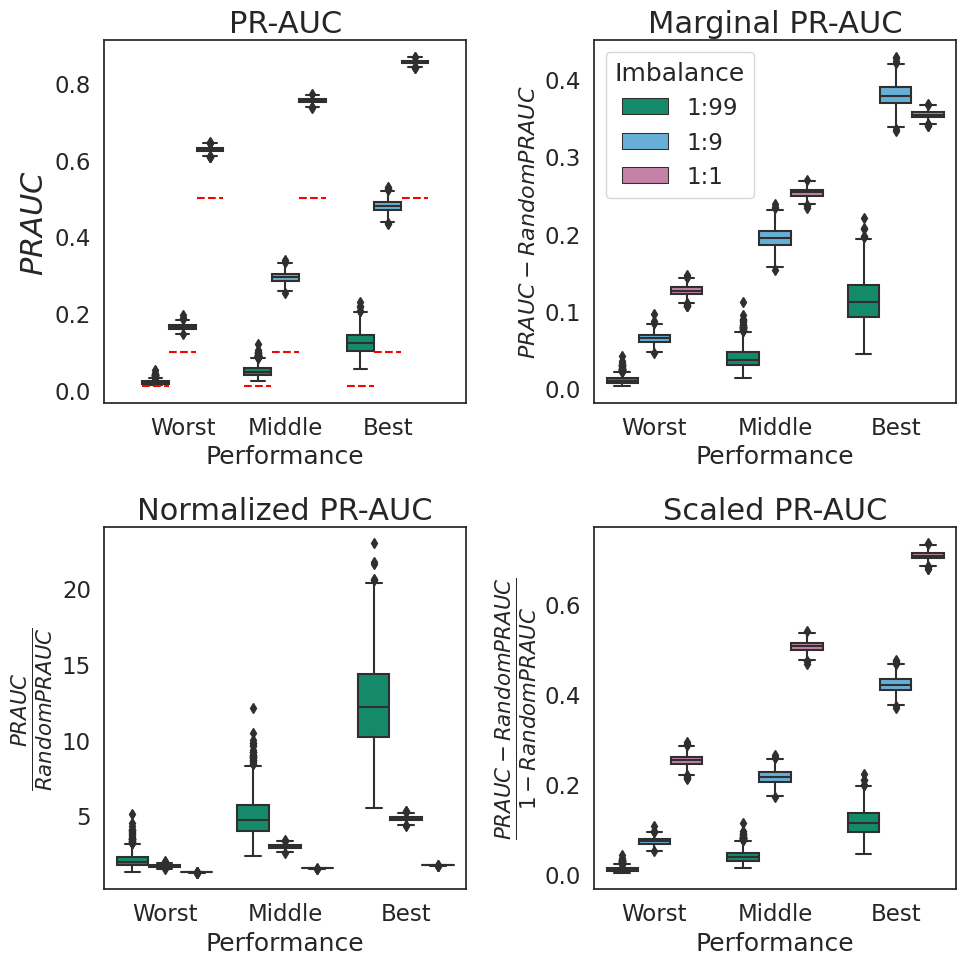

In [ ]:
# @title Supplementary Figure 2


fig, axs = plt.subplots(2, 2, figsize=(10,10))
pr_estimates = pd.read_csv(os.path.join(figure_dir,f'PR_Estimates_{simulation_type}.csv'))
pr_estimates['Performance'] = pr_estimates['mean_diff'].map(lambda x:'Worst' if x == 0.5 else 'Middle' if x == 1 else 'Best')
pr_estimates['PR-AUC_Marginal'] = pr_estimates['PR-AUC'] - pr_estimates['imbalance']
pr_estimates['PR-AUC_Ratio'] = pr_estimates['PR-AUC_Marginal'] / (pr_estimates['imbalance'])
pr_estimates['PR-AUC_Normalized'] = pr_estimates['PR-AUC'] / pr_estimates['imbalance']
pr_estimates['PR-AUC_Normalized_SqrdDenom'] = pr_estimates['PR-AUC'] / pr_estimates['imbalance']**2
pr_estimates['PR-AUC_Scaled'] = (pr_estimates['PR-AUC'] - pr_estimates['imbalance'])/(1 - pr_estimates['imbalance'])
pr_estimates['Classifier type'] = pr_estimates['mean_diff'].map(lambda x:'Worst' if x==0.5 else 'Middle' if x== 1 else 'Best')
pr_estimates['imbalance'] = pr_estimates['imbalance'].map(lambda x:'1:99' if x == .01 else '1:9' if x == .1 else '1:1')

sns.boxplot(data = pr_estimates, x='Performance', y ='PR-AUC', hue = 'imbalance', ax = axs[0][0], palette = imbalance_hex)
sns.boxplot(data = pr_estimates, x='Performance', y ='PR-AUC_Marginal', hue = 'imbalance', ax = axs[0][1], palette = imbalance_hex)
sns.boxplot(data = pr_estimates, x='Performance', y ='PR-AUC_Normalized', hue = 'imbalance', ax = axs[1][0], palette = imbalance_hex)
sns.boxplot(data = pr_estimates, x='Performance', y ='PR-AUC_Scaled', hue = 'imbalance', ax = axs[1][1], palette = imbalance_hex)


axs[0][0].set_xlabel('Performance')
axs[0][0].set_title(f'PR-AUC', size = 22)
axs[0][0].set_ylabel(r'$PRAUC$', size = 22)

n = 0
for patch in axs[0][0].patches:
  if type(patch) == mpatches.PathPatch:
    trans = patch.get_patch_transform()
    points = trans.transform(patch.get_path().vertices)
    index = n%3
    axs[0][0].plot([points[0][0],points[1][0]], [imbalances_float[index]]*2, color = 'red', linestyle = '--')
    n += 1

axs[0][1].set_xlabel('Performance')
axs[0][1].set_title(f'Marginal PR-AUC', size = 22)
axs[0][1].set_ylabel(r'$PRAUC - Random PRAUC$', size = 16)

axs[1][0].set_xlabel('Performance')
axs[1][0].set_title(f'Normalized PR-AUC', size = 22)
axs[1][0].set_ylabel(r'$\frac{PRAUC}{Random PRAUC}$', size = 22)

axs[1][1].set_xlabel('Performance')
axs[1][1].set_title(f'Scaled PR-AUC', size = 22)
axs[1][1].set_ylabel(r'$\frac{PRAUC - Random PRAUC}{1 - Random PRAUC}$', size = 22)

for n, ax in enumerate(axs[0]):
  if n != 1:
    ax.get_legend().remove()
  else:
    ax.get_legend().set_title('Imbalance')
for n, ax in enumerate(axs[1]):
  ax.get_legend().remove()
  # ax.set_xticklabels(imbalances_string)
fig.tight_layout()
plt.savefig('/content/drive/MyDrive/ROC-AUC_FinalFigs/Figure6.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('/content/drive/MyDrive/ROC-AUC_FinalFigs/Figure6.svg', format = 'svg')

In [ ]:
def draw_distrib(n, imbalance,  mean):
  n_pos = int(n * imbalance)
  scores = np.random.normal(0, 1, n)
  labels = np.zeros(n)
  scores[:n_pos] = np.random.normal(mean, 1, n_pos)
  labels[:n_pos] = 1
  return labels, scores

changing = {'Imbalance':[],'PR-AUC':[], 'Performance':[],'ROC-AUC':[]}
for k in range(1,99):
  imbalance = k/100
  distrib = er_distrib(100000, er = 'good', imbalance = imbalance)
  pr_auc = average_precision_score(distrib[0], distrib[1])
  roc_auc = roc_auc_score(distrib[0], distrib[1])
  changing['Imbalance'].append(imbalance)
  changing['PR-AUC'].append(pr_auc)
  changing['Performance'].append('Middle')
  changing['ROC-AUC'].append(roc_auc)
  distrib = er_distrib(100000, er = 'bad', imbalance = imbalance)
  pr_auc = average_precision_score(distrib[0], distrib[1])
  roc_auc = roc_auc_score(distrib[0], distrib[1])
  changing['Imbalance'].append(imbalance)
  changing['PR-AUC'].append(pr_auc)
  changing['Performance'].append('Worst')
  changing['ROC-AUC'].append(roc_auc)
changing = pd.DataFrame(changing)

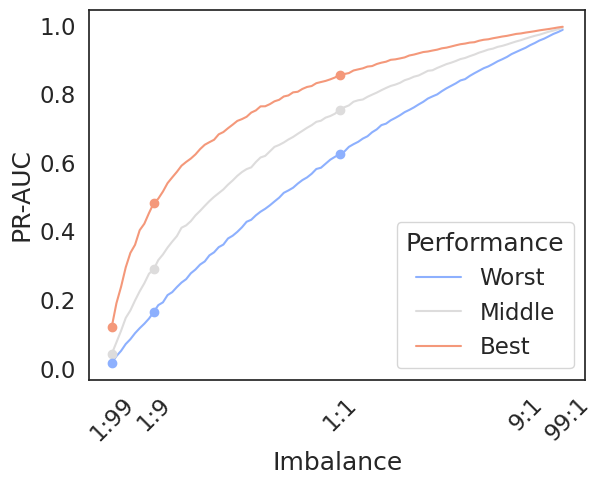

In [ ]:
def draw_distrib(n, imbalance,  mean):
  n_pos = int(n * imbalance)
  scores = np.random.normal(0, 1, n)
  labels = np.zeros(n)
  scores[:n_pos] = np.random.normal(mean, 1, n_pos)
  labels[:n_pos] = 1
  return labels, scores

changing = {'Imbalance':[],'PR-AUC':[], 'Performance':[]}
for k in range(1,99):
  imbalance = k/100
  distrib = draw_distrib(100000, mean = 1, imbalance = imbalance)
  pr_auc = average_precision_score(distrib[0], distrib[1])
  changing['Imbalance'].append(imbalance)
  changing['PR-AUC'].append(pr_auc)
  changing['Performance'].append('Middle')
  distrib = draw_distrib(100000, mean = 0.5, imbalance = imbalance)
  pr_auc = average_precision_score(distrib[0], distrib[1])
  changing['Imbalance'].append(imbalance)
  changing['PR-AUC'].append(pr_auc)
  changing['Performance'].append('Worst')
  distrib = draw_distrib(100000, mean = 1.5, imbalance = imbalance)
  pr_auc = average_precision_score(distrib[0], distrib[1])
  changing['Imbalance'].append(imbalance)
  changing['PR-AUC'].append(pr_auc)
  changing['Performance'].append('Best')
changing = pd.DataFrame(changing)

# fig, axs = plt.subplots(4, 1, figsize=(10,10))
changing['Performance_int'] = changing['Performance'].map(lambda x:0 if x=='Worst' else 1 if x=='Middle' else 2)
ax = sns.lineplot(data = changing.sort_values('Performance_int'), x = 'Imbalance', y = 'PR-AUC', hue = 'Performance', palette = 'coolwarm')
colors = sns.color_palette('coolwarm', n_colors = 3)
order = ['Worst', 'Middle', 'Best']
for x, (k,p) in enumerate(changing.groupby('Performance')):
    for imbalance in [.01, .1, .5]:
      m = p[p['Imbalance']==imbalance].iloc[0]['PR-AUC']
      ax.plot(imbalance, m, color=colors[order.index(k)], marker='o')
ax.set_xticks([0.01, 0.1, 0.5, 0.9, 0.99], labels=['1:99','1:9','1:1','9:1','99:1'], rotation = 45)
plt.savefig('/content/drive/MyDrive/ROC-AUC_FinalFigs/Figure6B.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('/content/drive/MyDrive/ROC-AUC_FinalFigs/Figure6B.svg', dpi = 600, bbox_inches = 'tight', format = 'svg')

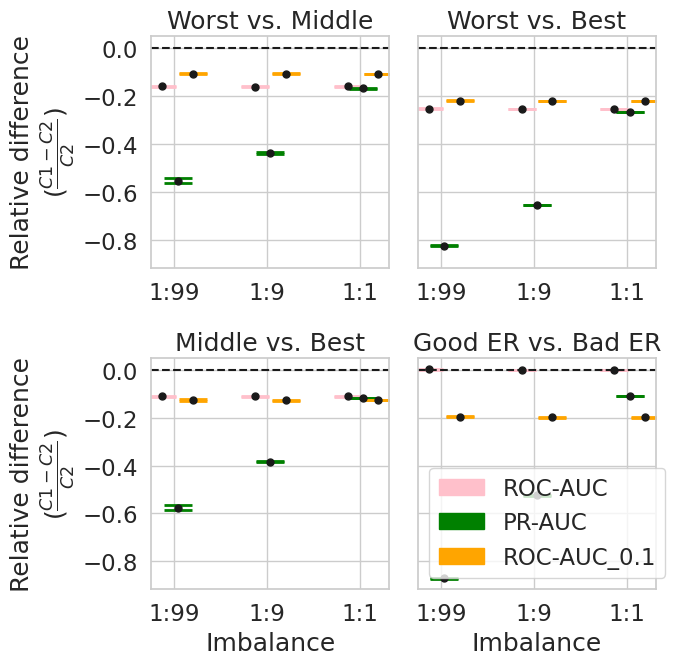

In [ ]:
# @title Supplementary Figure 3

norm = True
pr_estimates_diff = calc_estimates_diff(pr_estimates, mean_diffs, norm = norm)
pr_estimates_diff['p'] = pr_estimates_diff['p1'].map(str)+'_'+pr_estimates_diff['p2'].map(str)
classifier_labels = dict((p,z) for p,z in zip(mean_diffs,classifier_names))

pairs = [f'{x:.1f}_{y:.1f}' for x,y in combinations(mean_diffs, 2)]
n_pairs = len(pairs)
with sns.axes_style('whitegrid'):
  fig, axs = plt.subplots(2, 2, figsize=(7,7), sharey=True)
ylabel = 'Relative difference\n'+r"$(\frac{C1 - C2}{C2})$" if norm == True else 'Mean difference (worse classifier -\n better classifier)'
# pr_estimates_diff = pr_estimates_diff[pr_estimates_diff['metric']!='ROC-AUC_0.1']
row = 0
for n, comparison in enumerate(pairs):
  if n > 1:
    row += 1
  ax = axs[row][n%2]
  mean_list = list(pr_estimates_diff[pr_estimates_diff['p']==comparison]['mean_diff'].values)
  sem_list = list(pr_estimates_diff[pr_estimates_diff['p']==comparison]['err'].values)
  metric_types = ['ROC-AUC','PR-AUC','ROC-AUC_0.1']
  colors = ['pink','green','orange']
  index = .75
  imbalances = ['1:99']
  x_coords = [index]
  first_balance = pr_estimates_diff[pr_estimates_diff['p']==comparison].sort_values('imbalance',ascending=False).iloc[0]['imbalance']
  for x,(k,p) in enumerate(pr_estimates_diff[pr_estimates_diff['p']==comparison].sort_values('imbalance',ascending=False).iterrows()):
      color = colors[metric_types.index(p.metric)]
      if x != 0:
        if p.imbalance != first_balance:
          index += 1
          imbalances.append(p.imbalance)
          x_coords.append(index)
        else:
          index += .25

        first_balance = p.imbalance
      ax.errorbar(y=[p.mean_diff], x=index, yerr=[p.err], fmt='o', ms=5, color='k',capthick=2,ecolor=color,capsize=10, elinewidth=2)
  ax.axhline(0,linestyle='--',color='k')
  ax.set_xticks([p+.2 for p in x_coords], imbalances)
  if x == 0:
    ax.set_ylabel(ylabel)
  compared = sorted([float(p) for p in comparison.split('_')])
  ax.set_title(f'{classifier_labels[compared[0]]} vs. {classifier_labels[compared[1]]}')
axs[0][0].set_ylabel(ylabel)
axs[1][0].set_ylabel(ylabel)
red_patch = mpatches.Patch(color='pink', label='ROC-AUC')
pink_patch = mpatches.Patch(color='green', label='PR-AUC')
plt.legend(handles = [red_patch,pink_patch])

pr_estimates_diff_er = calc_estimates_diff(pr_estimates_er, ['good','bad'], norm = norm)
pr_estimates_diff_er['p'] = pr_estimates_diff_er['p1'].map(str)+'_'+pr_estimates_diff_er['p2'].map(str)
comparison = 'bad_good'
metric_types = ['ROC-AUC','PR-AUC','ROC-AUC_0.1']
colors = ['pink','green','orange']

index = .75
imbalances = ['1:99']
x_coords = [index]
first_balance = pr_estimates_diff_er[pr_estimates_diff_er['p']==comparison].sort_values('imbalance',ascending=False).iloc[0]['imbalance']
ax = axs[1][1]
for x,(k,p) in enumerate(pr_estimates_diff_er[pr_estimates_diff_er['p']==comparison].sort_values('imbalance',ascending=False).iterrows()):
    color = colors[metric_types.index(p.metric)]
    if x != 0:
      if p.imbalance != first_balance:
        index += 1
        imbalances.append(p.imbalance)
        x_coords.append(index)
      else:
        index += .25

      first_balance = p.imbalance
    ax.errorbar(y=[p.mean_diff], x = index, yerr = [p.err], fmt='o', ms=5, color='k',capthick=2,ecolor=color,capsize=10, elinewidth=2)
ax.axhline(0,linestyle='--',color='k')
ax.set_xticks([p+.2 for p in x_coords], imbalances)
red_patch = mpatches.Patch(color='pink', label='ROC-AUC')
pink_patch = mpatches.Patch(color='green', label='PR-AUC')
orange_patch = mpatches.Patch(color='orange', label='ROC-AUC_0.1')
ax.legend(handles = [red_patch,pink_patch,orange_patch])
ax.set_xlabel('Imbalance')
ax.set_title(f'Good ER vs. Bad ER')
axs[1][0].set_xlabel('Imbalance')
fig.tight_layout()
plt.savefig(os.path.join(figure_dir,'SupplementaryFigure3.png'), dpi = 600)
plt.savefig(os.path.join(figure_dir,'SupplementaryFigure3.svg'), dpi = 600, format = 'svg')

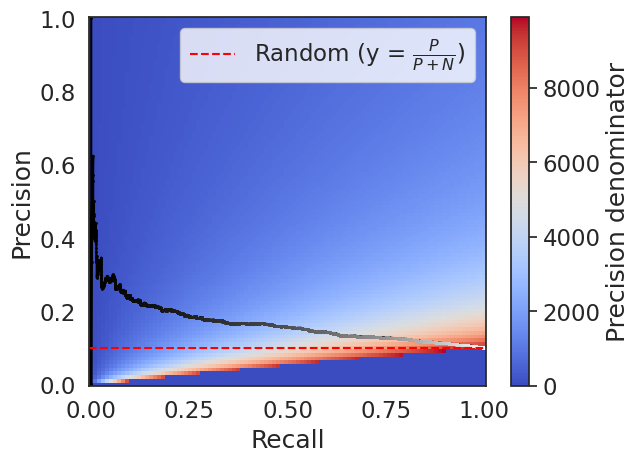

In [ ]:
# @title Supplementary Figure 5

def return_matrix(predictions, true, aim_p, aim_r):
    friends = list(zip(predictions, true))
    if aim_r == 0:
      return -10, -10
    if aim_p == 0:
      return -10, -10
    ir = int(aim_r * sum(true))
    total_preds = int(np.ceil(ir * (1 / aim_p)))
    negs = total_preds - ir
    if total_preds > len(predictions):
      return -10, -10
    else:
      pos = [1 for p in friends if p[1]==1]
      neg = [1 for p in friends if p[1]==0]
      if ir <= len(pos):
        if negs <= len(neg):
          pos = pos[:ir]
          neg = neg[:negs]
          assert len(pos)+len(neg)==total_preds
          return np.hstack([np.ones(len(pos)), np.zeros(len(neg))]), np.hstack([np.array(pos), np.array(neg)])
        else:
          return -10, -10
      else:
        return -10, -10

example = datasets[np.random.randint(len(datasets))][(0.1, 0.5)]
mesh_x = np.linspace(0, 1.00, 100)
mesh_y = np.linspace(0, 1.00, 100)
dataset_size = {}
for recall in mesh_x:
  dataset_size[recall] = {}
  for precision in mesh_y:
    X, y = return_matrix(example[1], example[0], precision, recall)
    if type(X)==int:
      dataset_size[recall][precision] = X
    elif len(set(y))>1:
      tn, fp, fn, tp = confusion_matrix(X,y).ravel()
      dataset_size[recall][precision] = sum([tp,fp])
    else:
      dataset_size[recall][precision] = len(X)

dataset_size = pd.DataFrame(dataset_size)
p, r, _ = precision_recall_curve(*example)
fig, ax = plt.subplots(1,1)
ax.plot(r,p,color='black')
color_scheme = sns.color_palette("binary", n_colors=len(_)+1)
for re, pr, col in zip(r, p, color_scheme):
  ax.plot(re, pr, '.', ms = 2, color = col)
cf = ax.pcolormesh(dataset_size.index, dataset_size.columns, dataset_size, cmap = 'coolwarm')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
fig.colorbar(cf, ax = ax, label = 'Precision denominator')
ax.axhline(0.1, color = 'red', linestyle = '--')
line = Line2D([0], [0], label = r'Random (y = $\frac{P}{P+N}$)', color = 'red', linestyle = '--')
handles, labels = plt.gca().get_legend_handles_labels()
handles = [line]
plt.legend(handles=handles)


In [ ]:
# @title Supplementary Table 3
mean = [1, 1]
values = {'Imbalance':[],'Corr':[],'ROC-AUC':[], 'PR-AUC':[],'n':[]}
for corr_coef in [0, .2, .4, .6, .8]:
  for x in range(1000):
    cov = [[1,corr_coef],[corr_coef,1]]
    labels, scores = np.random.multivariate_normal(mean, cov, 10000).T
    for n, imbalance in enumerate(imbalances_float):
        points = (-labels).argsort()[:int(imbalance*10000)]
        copy = np.zeros(10000)
        copy[points] = 1
        pr = average_precision_score(copy, scores)
        roc = roc_auc_score(copy, scores)
        values['Imbalance'].append(imbalance)
        values['Corr'].append(corr_coef)
        values['ROC-AUC'].append(roc)
        values['PR-AUC'].append(pr)
        values['n'].append(x)
values = pd.DataFrame(values)
values.groupby(['Imbalance','Corr']).apply(lambda x:x[['ROC-AUC','PR-AUC']].median(0)).reset_index().pivot(index=['Corr'],columns=['Imbalance'], values=['ROC-AUC'])

Text(0.1, 1, '$\\rho$: 0.2')

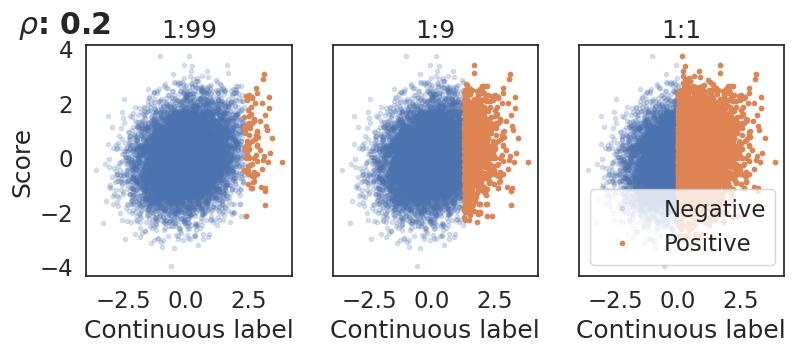

In [ ]:
# @title Supplementary Figure 6
corr_coef = .2
mean = [0,0]
cov = [[1,corr_coef],[corr_coef,1]]
labels, scores = np.random.multivariate_normal(mean, cov, 10000).T
imbalances = [.01, .1, .5]
fig, axes = plt.subplots(1,3,figsize=(9,3),sharey=True,sharex=True)
for n, imbalance in enumerate(imbalances):
  ax = axes[n]
  ax.plot(labels, scores, '.', alpha=.2, color='C0')
  points = (-labels).argsort()[:int(imbalance*10000)]
  copy = np.zeros(10000)
  copy[points] = 1
  ax.plot(labels[points], scores[points], '.', color='C1')
  ax.set_title(imbalances[n])
  ax.set_xlabel('Continuous label')
  if n == 0:
    ax.set_ylabel('Score')
  ax.set_title(imbalances_string[n])
plt.legend(['Negative','Positive'])
plt.suptitle(r"$\rho$: "+str(corr_coef), fontweight='bold', y = 1, x= 0.1)